In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : qORyHJGG 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : SBZUMuu8
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

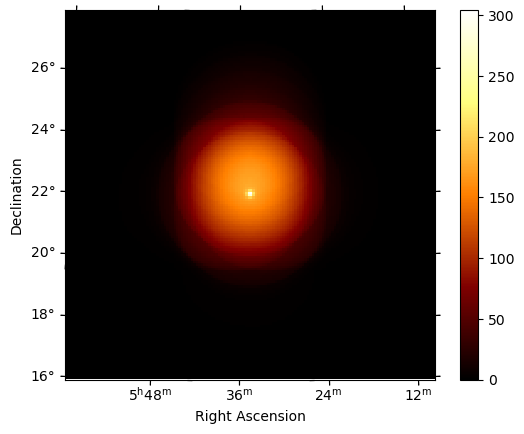

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models_input = Models(source_model)
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

asimov = True
if asimov:
    dataset_standard.counts = dataset_standard.npred()
    
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(    "spatial binsize = ",    binsize)

print(dataset_standard)
fit = Fit()
#result = fit.run(dataset_standard)

In [4]:
shift = 0.8
#dataset_standard = MapDataset.read(f"stacked_shifted{shift}.fits.gz")



## Option 2: Change the IRF

      """Convolve map data with energy dispersion.

        Parameters
        ----------
        npred : `~gammapy.maps.Map`
            Predicted counts in true energy bins

        Returns
        -------
        npred_reco : `~gammapy.maps.Map`
            Predicted counts in reco energy bins
        """
        return npred.apply_edisp(self.edisp)
        
        
    def apply_edisp(self, edisp):
        """Apply energy dispersion to map. Requires energy axis.

        Parameters
        ----------
        edisp : `gammapy.irf.EDispKernel`
            Energy dispersion matrix

        Returns
        -------
        map : `WcsNDMap`
            Map with energy dispersion applied.
        """
        # TODO: either use sparse matrix mutiplication or something like edisp.is_diagonal
        if edisp is not None:
            loc = self.geom.axes.index("energy_true")
            data = np.rollaxis(self.data, loc, len(self.data.shape))
            data = np.dot(data, edisp.pdf_matrix)
            data = np.rollaxis(data, -1, loc)
            energy_axis = edisp.axes["energy"].copy(name="energy")
        else:
            data = self.data
            energy_axis = self.geom.axes["energy_true"].copy(name="energy")

        geom = self.geom.to_image().to_cube(axes=[energy_axis])
        return self._init_copy(geom=geom, data=data)

###  Edisp Structure

`dataset.edisp` = `EDispKernelMap` (`peek`)

`EDispKernel` = `EDispKernelMap.get_edisp_kernel()` (`get_mean`, `get_bias`)

`WcsNDMap` = `EDispKernelMap.edisp_map`

In [5]:
edispKernelMap_standard = dataset_standard.edisp
edispKernel_standard = edispKernelMap_standard.get_edisp_kernel()
edispMap_standard = edispKernelMap_standard.edisp_map

In [6]:
def shift_axis(geom_original,shift):
    shifted_eaxis = MapAxis(nodes = geom_original.axes['energy_true'].edges * shift, 
                            interp='log', name='energy_true', node_type='edges')

    return shifted_eaxis

def shift_edisp(edisp_original, shift):
    shift_geom = shift_geom(edispMap_standard.geom, shift)
    
    

<WCSAxesSubplot: >

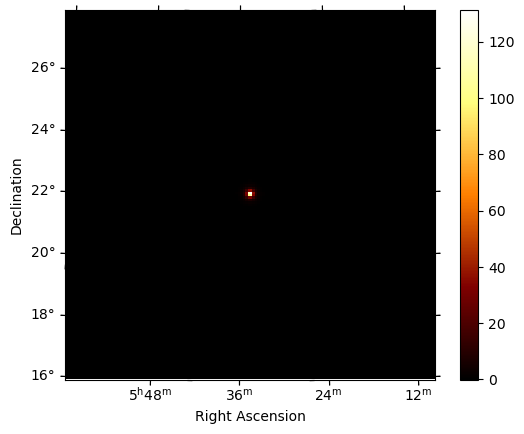

In [7]:
dataset_simulated = dataset_standard.copy()



shifted_eaxis = shift_axis(dataset_simulated.exposure.geom, 0.9)
dataset_simulated.exposure.geom.resample_axis(shifted_eaxis)
dataset_simulated.edisp.edisp_map.geom.resample_axis(shifted_eaxis)

models_simulated = Models(source_model)
bkg_model_simulated = FoVBackgroundModel(dataset_name=dataset_simulated.name)
bkg_model_simulated.parameters['tilt'].frozen  = False
models_simulated.append(bkg_model_simulated)
dataset_simulated.models = models_simulated
dataset_simulated.counts = dataset_simulated.npred()
dataset_simulated.npred_signal().sum_over_axes().plot(add_cbar =1)


In [8]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

Text(0.5, 0, 'Standard Energy [TeV]')

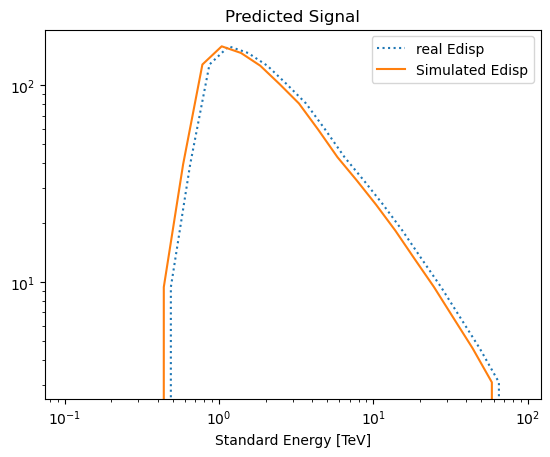

In [13]:
plt.title("Predicted Signal")
plt.plot( dataset_standard.exposure.geom.axes[0].center.value,
         sum_e(dataset_standard.npred_signal().data), ':',label = "real Edisp")
plt.plot( dataset_standard.exposure.geom.axes[0].center.value,
         sum_e(dataset_simulated.npred_signal().data),  label = "Simulated Edisp")
plt.loglog()
plt.legend()
plt.xlabel("Standard Energy [TeV]")

NameError: name 'eaxis_standard' is not defined

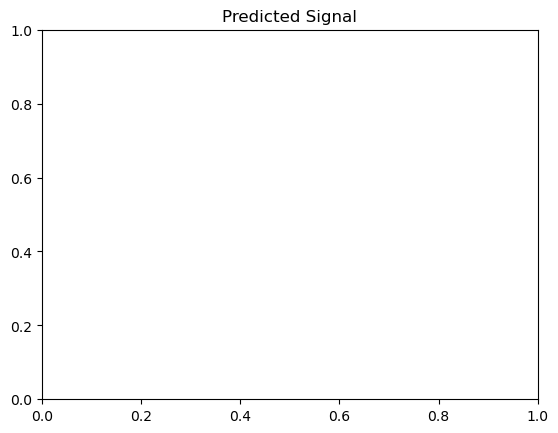

In [14]:
plt.title("Predicted Signal")
plt.plot(eaxis_standard.center, sum_e(dataset_standard.npred_signal().data), ':',label = "real Edisp")
plt.plot(eaxis_standard.center, sum_e(dataset_simulated.npred_signal().data), label = "Simulated Edisp")
plt.plot(eaxis_standard.center, sum_e(dataset_simulated_shifted.npred_signal().data), label = "Simulated Shifted Edisp")

plt.loglog()
plt.legend()
plt.xlabel("Standard Energy [TeV]")

In [ ]:
dataset_simulated.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")


In [ ]:
print(dataset_simulated.models)

In [ ]:
dataset_simulated_shifted.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")


`test_edisp_kernel.data += bias_shift`
does not work


## After Fitting:

In [ ]:
%%time
fit = Fit()
result = fit.run(dataset_simulated)
result = fit.run(dataset_simulated_shifted)

In [ ]:
print(dataset_simulated.models)

In [ ]:
dataset_simulated.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")


In [ ]:
dataset_simulated_shifted.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")


In [ ]:
mask = dataset_simulated.mask.data[:,60,60]
ebins = dataset_simulated.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV


In [ ]:
fig, axs = plt.subplots(1,1,figsize = (5,3) )

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

dataset_simulated.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "No Shift", color = "red", )
dataset_simulated.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                                    facecolor = "red", alpha = 0.2,
                                                     label = "Error No Shift")
dataset_simulated_shifted.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Shift", color = "blue", )
dataset_simulated_shifted.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                                    facecolor = "blue", alpha = 0.2,
                                                             label = "Error Shift")
axs.legend()
axs.set_xlabel("Energy [TeV]")
plt.tight_layout()


In [ ]:
fig = plt.figure(figsize = (10,3))
par_standard = dataset_standard.models.parameters.free_parameters
par_shifted = dataset_simulated.models.parameters.free_parameters
par_shifted_N = dataset_simulated_shifted.models.parameters.free_parameters


inputs = models_input.parameters.free_parameters.value
inputs = np.append(inputs, [1.0, 1.0, 1.0])
names = []
for i in range(len( par_shifted)):
    p_st = par_standard[i].copy()
    p_sh = par_shifted[i].copy()
    p_sh_N = par_shifted_N[i].copy()
    names.append(p_st.name)
    if p_st.name == "tilt":
        p_st.value +=1 
        p_sh.value +=1 
        p_sh_N.value +=1 
        
    plt.errorbar(i, p_st.value / inputs[i],yerr = p_st.error/inputs[i] , fmt = 'o', color = 'green',
                label = 'Input')
    plt.errorbar(i+0.1 , p_sh_N.value / inputs[i],yerr = p_sh_N.error/inputs[i] , fmt = 'o', color = 'royalblue',
                label = 'With Shift')
    plt.errorbar(i+ 0.2, p_sh.value / inputs[i],yerr = p_sh.error/inputs[i], fmt =  'o', color = 'red',
                label = 'No Shift')
xlim = plt.xlim()
plt.hlines(1, xlim[0], xlim[1] )    
plt.xticks(np.arange(len(names)), names);    
plt.ylabel("Best Fit value [input value]")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Accounting by changing the ref. energy")
